## MNIST and Softmax

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [3]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root = 'MNIST_data/',
                         train = True,
                         transform = transforms.ToTensor(),
                         download = True)
mnist_test = dsets.MNIST(root = 'MNIST_data/',
                         train = False,
                         transform = transforms.ToTensor(),
                         download = True)

In [5]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True)

test_loader = torch.utils.data.DataLoader(dataset = mnist_test,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         drop_last = True)

In [6]:
# nn layers
linear1 = torch.nn.Linear(784, 32, bias = True)
linear2 = torch.nn.Linear(32, 32, bias = True)
linear3 = torch.nn.Linear(32, 10, bias = True)

relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias = True)
nn_linear2 = torch.nn.Linear(32, 32, bias = True)
nn_linear3 = torch.nn.Linear(32, 10, bias = True)

In [7]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                              linear2, bn2, relu,
                              linear3).to(device)

nn_model = torch.nn.Sequential(nn_linear1, relu,
                              nn_linear2, relu,
                              nn_linear3).to(device)

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr = learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr = learning_rate)

In [11]:
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

for epoch in range(training_epochs):
    bn_model.train()
    
    for X, y in train_loader:
        X = X.view(-1, 28 * 28).to(device)
        y = y.to(device)
        
        bn_optimizer.zero_grad()
        bn_pred = bn_model(X)
        bn_loss = criterion(bn_pred, y)
        bn_loss.backward()
        bn_optimizer.step()
        
        nn_optimizer.zero_grad()
        nn_pred = nn_model(X)
        nn_loss = criterion(nn_pred, y)
        nn_loss.backward()
        nn_optimizer.step()
        
    with torch.no_grad():
        bn_model.eval()
        
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            y = y.to(device)
            
            bn_pred = bn_model(X)
            bn_correct_pred = torch.argmax(bn_pred, 1) == y
            bn_loss += criterion(bn_pred, y)
            bn_acc += bn_correct_pred.float().mean()
            
            nn_pred = nn_model(X)
            nn_correct_pred = torch.argmax(nn_pred, 1) == y
            nn_loss += criterion(nn_pred, y)
            nn_acc += nn_correct_pred.float().mean()
            
        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch
        
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-Train] Batchnorm Loss(Acc) : bn_loss:%.5f(bn_acc:%.2f) VS No Batchnorm Loss(Acc) : nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            y = y.to(device)
            
            bn_pred = bn_model(X)
            bn_correct_pred = torch.argmax(bn_pred, 1) == y
            bn_loss += criterion(bn_pred, y)
            bn_acc += bn_correct_pred.float().mean()
            
            nn_pred = nn_model(X)
            nn_correct_pred = torch.argmax(nn_pred, 1) == y
            nn_loss += criterion(nn_pred, y)
            nn_acc += nn_correct_pred.float().mean()
            
        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch
        
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-Valid] Batchnorm Loss(Acc) : bn_loss:%.5f(bn_acc:%.2f) VS No Batchnorm Loss(Acc) : nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()
        
print('Learning Finished.')

[Epoch 1-Train] Batchnorm Loss(Acc) : bn_loss:0.08179(bn_acc:0.97) VS No Batchnorm Loss(Acc) : nn_loss:0.15961(nn_acc:0.95)
[Epoch 1-Valid] Batchnorm Loss(Acc) : bn_loss:0.10647(bn_acc:0.97) VS No Batchnorm Loss(Acc) : nn_loss:0.19985(nn_acc:0.95)

[Epoch 2-Train] Batchnorm Loss(Acc) : bn_loss:0.07464(bn_acc:0.98) VS No Batchnorm Loss(Acc) : nn_loss:0.18743(nn_acc:0.95)
[Epoch 2-Valid] Batchnorm Loss(Acc) : bn_loss:0.09791(bn_acc:0.97) VS No Batchnorm Loss(Acc) : nn_loss:0.22018(nn_acc:0.94)

[Epoch 3-Train] Batchnorm Loss(Acc) : bn_loss:0.06744(bn_acc:0.98) VS No Batchnorm Loss(Acc) : nn_loss:0.12913(nn_acc:0.96)
[Epoch 3-Valid] Batchnorm Loss(Acc) : bn_loss:0.09045(bn_acc:0.97) VS No Batchnorm Loss(Acc) : nn_loss:0.17438(nn_acc:0.95)

[Epoch 4-Train] Batchnorm Loss(Acc) : bn_loss:0.06218(bn_acc:0.98) VS No Batchnorm Loss(Acc) : nn_loss:0.14859(nn_acc:0.96)
[Epoch 4-Valid] Batchnorm Loss(Acc) : bn_loss:0.09051(bn_acc:0.97) VS No Batchnorm Loss(Acc) : nn_loss:0.19968(nn_acc:0.95)

[Epo

In [12]:
def plot_compare(loss_list : list, ylim = None, title = None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]
    
    plt.figure(figsize = (15, 10))
    plt.plot(bn, label = 'With BN')
    plt.plot(nn, label = 'Without BN')
    if ylim:
        plt.ylim(ylim)
        
    if title:
        plt.title(title)
        
    plt.legend()
    plt.grid('on')
    plt.show()

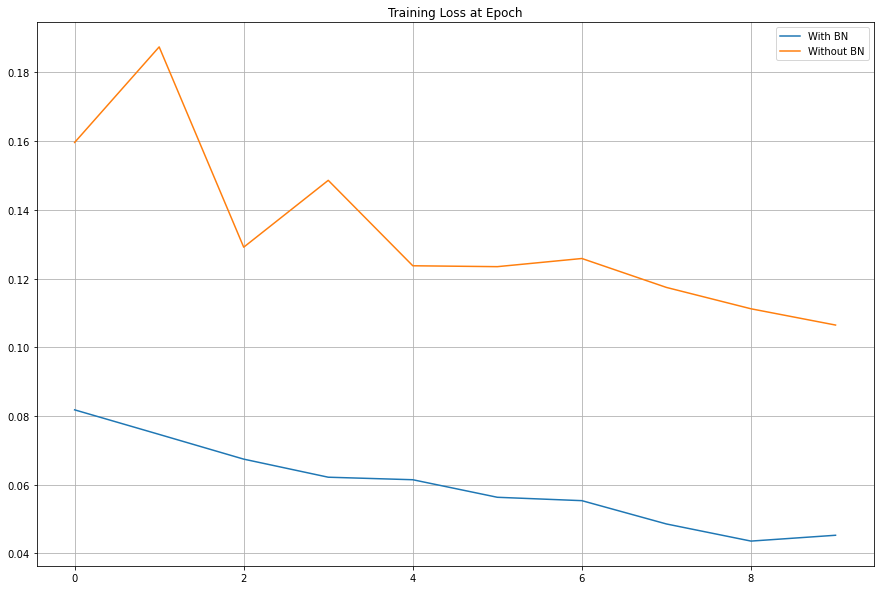

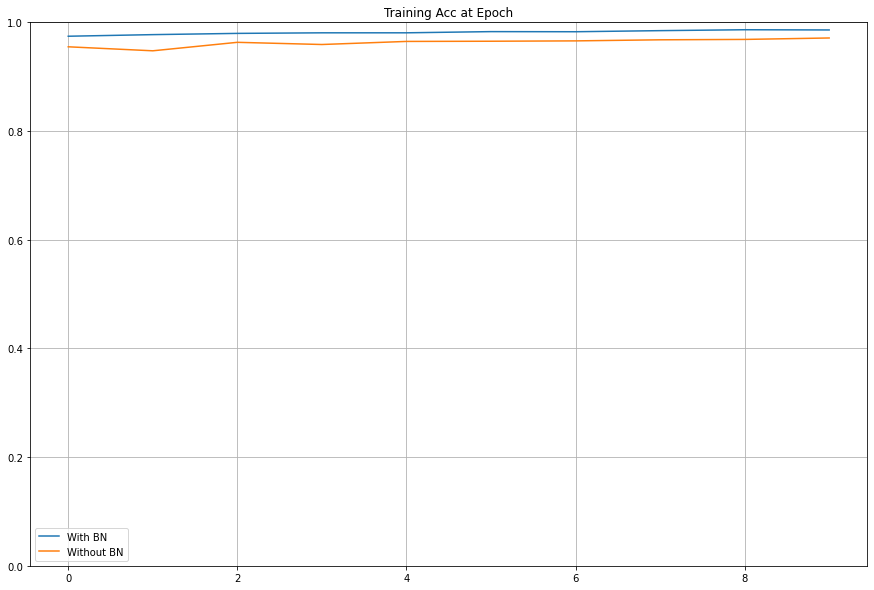

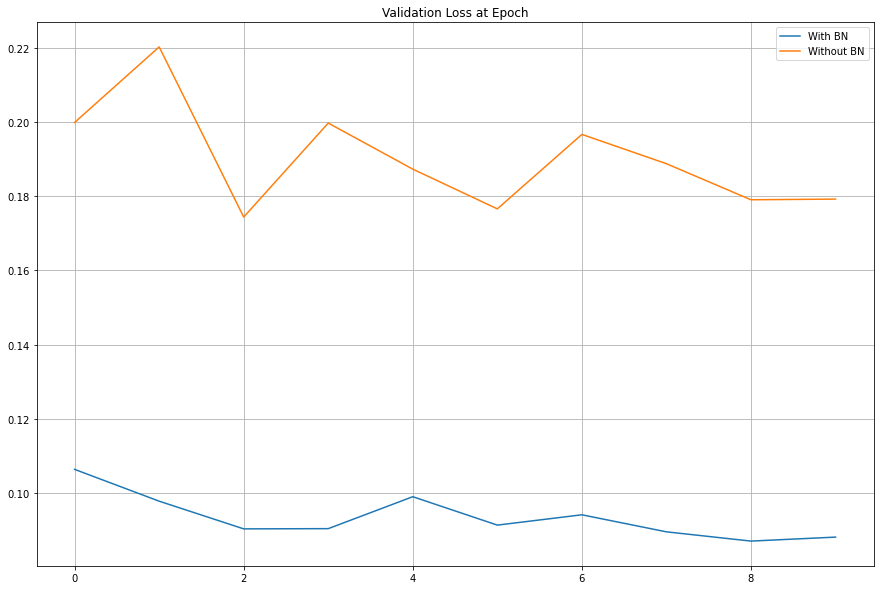

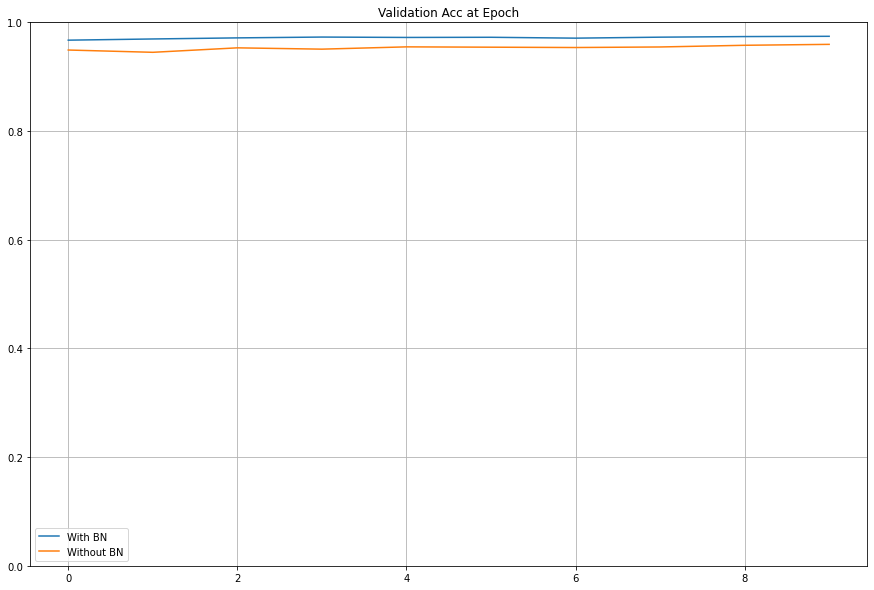

In [14]:
plot_compare(train_losses, title = 'Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title = 'Training Acc at Epoch')
plot_compare(valid_losses, title = 'Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title = 'Validation Acc at Epoch')